<a href="https://colab.research.google.com/github/Hadi-Saghir/Deep-Learning-Notebooks/blob/main/Lab_2_5TF078_Hadi_Saghir.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Lab 2: Transfer Learning**
## Author: Hadi Saghir (hasa0182)

This lab will demonstrate knowledge and ability to apply transfer learning (TA) in convolution neural netweorks (CNN).

This document will contain 4 parts:
- Prelude
- Applying the VGG16 model and expirmenting with the last layers.
- Fine tuning our model
- Applying the Xception model


**OBS! i got permission from Tomas to update my document only regarding feedback from lab 1**

# Prelude

##Intialize python enviroment anc check for the GPU

In [ ]:
# Import needed libraries
import tensorflow as tf
print('TensorFlow version:', tf.__version__)

# from tensorflow import keras
# from tensorflow.keras import layers

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras.utils  import to_categorical

import keras
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten

#from keras.layers.advanced_activations import LeakyReLU
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16;
from keras.applications import Xception;

print('Keras version:',tf.keras.__version__)

# Helper libraries
import numpy as np
import sklearn
from   sklearn.model_selection import train_test_split

# Matlab plotting
import matplotlib
import matplotlib.pyplot as plt

# Test for GPU and determine what GPU we have
import sys
if not tf.config.list_physical_devices('GPU'):
     print("No GPU was detected. CNNs can be very slow without a GPU.")
     IN_COLAB = 'google.colab' in sys.modules
     if IN_COLAB:
         print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
else:
     !nvidia-smi -L

TensorFlow version: 2.9.2
Keras version: 2.9.0
GPU 0: Tesla T4 (UUID: GPU-5d0243d2-6e21-d2c5-386d-962dd8e52db4)


### Define general attributes and functions

Defininf parameters, functions and classes that will be used by the all three parts. My generator will allow use to stream and transfer simultaneously while decrease he need for space as images will be streamed and processed in batches.

In [ ]:
from tensorflow.python.saved_model.model_utils.mode_keys import EstimatorModeKeys

# Define the parameters
IMG_WIDTH = 64
IMG_HEIGHT = 64
IMG_DEPTH = 3 #the img_transform changes 1 to 3 automatically when greyscale.to.rgb is called
input_shape = (IMG_WIDTH, IMG_HEIGHT, IMG_DEPTH)

BATCH_SIZE = 16 # batch size for generator (must be divisible by batch_size)
batch_size = 32 # batch size for training

# Define an in-stream transform (gray2color, resize)
def img_transform(images):
 images = tf.image.grayscale_to_rgb(tf.convert_to_tensor(images))
 images = tf.image.resize_with_pad(images, IMG_WIDTH, IMG_HEIGHT, antialias=False)
 return images

# Define a Sequence generator
class Mygenerator(tf.keras.utils.Sequence):
  def __init__(self, x_set, y_set, batch_size):
    self.x, self.y = x_set, y_set
    self.batch_size = batch_size

  def __len__(self):
    return int(np.ceil(len(self.x) / float(self.batch_size)))

  def __getitem__(self, idx):
    end = min(self.x.shape[0], (idx + 1)*batch_size)
    batch_x = self.x[idx * self.batch_size : end]
    batch_y = self.y[idx * self.batch_size : end]
    # transform the images to fit the model constraints
    x=img_transform(batch_x)
    print("batch_y = ", batch_y.shape)
    y=to_categorical(batch_y)
    print("y = ", y.shape)
    return np.array(x), np.array(y)


## Set up the dataset



In [ ]:
# Get Fashion-MNIST training and test data from Keras database (https://keras.io/datasets/)
dir_path_train = "/kaggle/input/fast-food-classification-dataset/Fast Food Classification V2/Train"
dir_path_test = "/kaggle/input/fast-food-classification-dataset/Fast Food Classification V2/Test"
dir_path_valid = "/kaggle/input/fast-food-classification-dataset/Fast Food Classification V2/Valid"
(train_images0, train_labels0), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()

# Define labels
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Split the training set into a training and a validation set (20% is validation)
train_images, val_images, train_labels, val_labels = train_test_split(train_images0, train_labels0, test_size=0.20)

# Add an "empty" color dimension for our data sets
train_images = np.expand_dims(train_images, -1)
val_images = np.expand_dims(val_images, -1)
test_images = np.expand_dims(test_images, -1)

# Generate data streams of from data sets (OBS! block of code for resize of entire dataset)
train_gen = Mygenerator(train_images, train_labels, batch_size = BATCH_SIZE )
val_gen = Mygenerator(train_images, train_labels, batch_size = BATCH_SIZE )
test_gen = Mygenerator(test_images, test_labels, batch_size = BATCH_SIZE)


4422102/4422102 [==============================] - 0s 0us/step


## resize entire dataset

In [ ]:
#make labels categorical
train_labels_cat = to_categorical(train_labels)
test_labels_cat = to_categorical(test_labels)
val_labels_cat = to_categorical(val_labels)

#resize dataset (attrbutes definied in the definition block found above)
train_images = img_transform(train_images)
val_images = img_transform(val_images)
test_images = img_transform(test_images)

### print info on the dataset

In [ ]:
#print info of the dataset
print(train_images.shape)
print(test_images.shape)
print(val_images.shape)

classes = np.unique(train_labels)
num_classes = len(classes)
print('Training labels:', np.unique(train_labels), "; That is,", num_classes,"classes." )

(48000, 64, 64, 3)
(10000, 64, 64, 3)
(12000, 64, 64, 3)
Training labels: [0 1 2 3 4 5 6 7 8 9] ; That is, 10 classes.


# Applying the VGG16 model and expirmenting with the last layers.

### Defining the model

In [ ]:
# Define out vgg_model
vgg_model = VGG16(    include_top=False,
                      weights="imagenet",
                      input_tensor= None,
                      input_shape = input_shape,
                      pooling=None,
                      classes=10,
                      classifier_activation="softmax",
                 )

# Creating dictionary that maps layer names to the layers
layer_dict = dict([(layer.name, layer) for layer in vgg_model.layers])

# Getting output tensor of the last VGG layer that we want to include
x = layer_dict['block3_pool'].output

# Stacking a new simple convolutional network on top of it
x = keras.layers.BatchNormalization(axis=-1)(x)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)
x = Dense(units=num_classes, activation='softmax')(x)

# Creating new model. Please note that this is NOT a Sequential() model.
from keras.models import Model
model = Model(vgg_model.input, x)

# Adjust the trainable layers are not trainable
for layer in model.layers[0:-5]:
    layer.trainable = False

model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                              

In [ ]:
# Compile the model
model.compile(
  optimizer='Adam',
  loss='categorical_crossentropy',
  metrics=['categorical_accuracy']
)

# Generate data streams from data sets
epochs = 100

es=tf.keras.callbacks.EarlyStopping(monitor='val_loss', verbose=1, patience=3, mode='auto', min_delta=0, restore_best_weights = True)
rl = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1, mode='auto', epsilon=0.0001, cooldown=2, min_lr=0)
callbacks =[es,rl]

"""
# Training using streams
history = model.fit(train_gen,
                    epochs=epochs,
                    steps_per_epoch=train_images.shape[0]
                    shuffle=True,
                    verbose=1,
                    validation_data=val_gen,
                    callbacks=callbacks)

# Evaluate
score = model.evaluate(test_gen)
print('Test Loss:', score[0])
print('Test accuracy:', score[1])
"""

# Training using existing data
history = model.fit(train_images, to_categorical(train_labels),
                    epochs=epochs,
                    shuffle=True,
                    verbose=1,
                    batch_size=batch_size,
                    validation_data=[val_images, to_categorical(val_labels)],
                    callbacks=callbacks
                    )

# Evaluate
test_loss, test_acc = model.evaluate(test_images, to_categorical(test_labels))


# Print evalutation
print('Test accuracy: %.3f' % test_acc)

Epoch 1/100
1500/1500 [==============================] - 18s 11ms/step - loss: 0.8588 - categorical_accuracy: 0.8554 - val_loss: 0.3955 - val_categorical_accuracy: 0.8670 - lr: 0.0010
Epoch 2/100
1500/1500 [==============================] - 16s 11ms/step - loss: 0.2765 - categorical_accuracy: 0.9001 - val_loss: 0.2597 - val_categorical_accuracy: 0.9044 - lr: 0.0010
Epoch 3/100
1500/1500 [==============================] - 16s 11ms/step - loss: 0.2330 - categorical_accuracy: 0.9165 - val_loss: 0.2431 - val_categorical_accuracy: 0.9126 - lr: 0.0010
Epoch 4/100
1500/1500 [==============================] - 16s 11ms/step - loss: 0.2093 - categorical_accuracy: 0.9246 - val_loss: 0.2217 - val_categorical_accuracy: 0.9233 - lr: 0.0010
Epoch 5/100
1500/1500 [==============================] - 16s 11ms/step - loss: 0.1782 - categorical_accuracy: 0.9370 - val_loss: 0.2577 - val_categorical_accuracy: 0.9154 - lr: 0.0010
Epoch 6/100
1498/1500 [============================>.] - ETA: 0s - loss: 0.1578 

### Explore the training progress
Show the training progress, by plotting the training and validation accuracy and loss

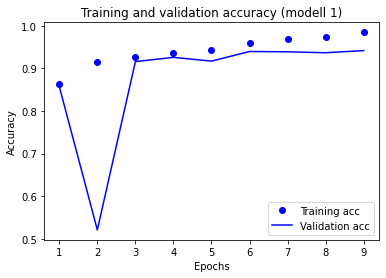

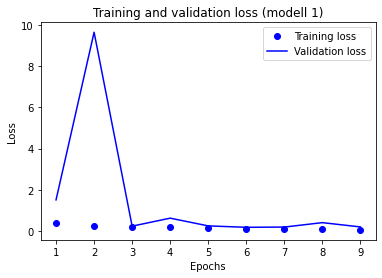

In [ ]:
epochrange = range(1, callbacks[0].stopped_epoch + 2) # change to the epoch it stopped at when adding the early stopping method
train_acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochrange, train_acc, 'bo', label='Training acc')
plt.plot(epochrange, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy (modell 1)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(epochrange, train_loss, 'bo', label='Training loss')
plt.plot(epochrange, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss (modell 1)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Evaluate the model on the test data.


In [ ]:
# Evaluate the model.
test_loss, test_acc = model.evaluate(test_images,to_categorical(test_labels))
print('Test accuracy: %.3f' % test_acc)

313/313 [==============================] - 4s 12ms/step - loss: 0.1799 - categorical_accuracy: 0.9413
Test accuracy: 0.941


## Analysis

### No trainble layers
I didn't know i set all layers trainble = false. The result was stagnation after the first epoch at accruacy below 0.1. It was nice to see how that i still got some accuracy, but i am not sure if it is because of the pre-trained model.

### Add trainble layers (VGG16 model is untrainble)
After sitting for hours to figure why i was getting appalling bad results, i set the last layers to true. Mt total parameters were 11 million but 0 trainable.

model:

x = keras.layers.BatchNormalization(axis=-1)(x)  
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)
x = Dense(units=num_classes, activation='softmax')(x)

The result jumped to 89.9%. One interesting trend i noted when i was trying to fine tune my additional layers was that my val_acc was 94% while the test_acc seemed low in comparison: 3-4% lower.

### Scaling the image even further
Applying the same model above, I scaled the image to (64,4). The test accuracy increased to 91.6%, but the val_accuracy was much higher still, so i guess it is over generalizing.

### Decreasing the patience on the EarlyStopping
I noticed that my (EarlyStopping) callbacks[0].patience = 10. Which is probably the reason for such early overfitting. I decreased the patience to 5 and instead of finishing on epoch 11, it finished on epoch 7. The result was 4 less epochs and a test_acc = 93%

### Further tweaks
I tried fiddling with the the image scale equal to (128,128) and (32,32), batch size equal to 28 or 128, and patience equal to 3 or 5, but they result was all relatively the same test_accuracy: 0.921. There wasn't much of a difference between the different tuning that are worth noting, and they all were on average 1% worse than my 93% attained earlier.

### Further analysis
Interesting tests for further analysis is to train blocks between untrained blocks -- test if that is even possible and its result.

# Fine-tuning our model

In [ ]:
# Define out vgg_model
vgg_model = VGG16(    include_top=False,
                      weights="imagenet",
                      input_tensor= None,
                      input_shape = input_shape,
                      pooling=None,
                      classes=10,
                      classifier_activation="softmax",
                 )

# Creating dictionary that maps layer names to the layers
layer_dict = dict([(layer.name, layer) for layer in vgg_model.layers])

# Getting output tensor of the last VGG layer that we want to include
x = layer_dict['block4_pool'].output

# Stacking a new simple convolutional network on top of it
x = keras.layers.BatchNormalization(axis=-1)(x)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)
x = Dense(units=num_classes, activation='softmax')(x)

# Creating new model. Please note that this is NOT a Sequential() model.
from keras.models import Model
model = Model(vgg_model.input, x)

# Adjust the trainable layers are not trainable
for layer in model.layers[0:10]:
    layer.trainable = False

model.summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0  

## Analysis

I was able to attain a 94.1% accuracy!

**The model i was using was the same for all of the different experiments**

* x = keras.layers.BatchNormalization(axis=-1)(x)  
* x = Flatten()(x)
* x = Dense(512, activation='relu')(x)
* x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)
* x = Dense(units=num_classes, activation='softmax')(x)

I will be fine-tuning the model by benchmarking the best amount of blocks to set to untrainable from pre-trained VGG16 model.

### Block3_pool (10 million params, 8 million trainable)

I started with block3_pool, which was the best fit for my previous attempt, but the result were underwhelming: capping at 92.6% accuracy in comparison to 92.7% to 93% with fewer parameter.

attempt 1: I tried untrainble={block1} and the rest trainble, and the model was quicking overfitting at the best_epoch = 3. test_acc = 0.981.

attempt 2: I tried untrainble={block1, block2} and the rest trainble, and the model was much more robust (train_acc and val_acc had a strong corelation) and only starting overfitting at the best_epoch = 9. test_acc = 0.926

### Block4_pool (11,837k params)

I started decided to increase to amount of blocks to 4, as i noticed more untrainable pre trained layers led often to better result, so in order to have 3 blocks of untrainble pre-trained layers to further build on to fine tune my model.

attempt 3: I tried untrainble={block1, block2, block3} and trainble={block4}, and the model was very robust (train_acc and val_acc were spot on) and only starting overfitting at the best_epoch = 7. test_acc = 0.941! I still cannot figure out the anomalous outlier at epoch 2: insansely low val_acc and high  val_loss. I left the graph and accuracy evalutaton as is, but the compilation i changed to test other models. (10,100k trainable params)

attempt 4: I tried untrainble={block1, block2} and trainble={block3, block4}, and the model was fluctuating (train_acc and val_acc were spot on) and starting overfitting fast with best_epoch = 5. test_acc = 0.899.

### Block5_pool

I tested 5 block to see if the trend, more blocks = higher accuracy, continues. However, this wasn't the case. test_acc was at best 90.3%.

### Conclusion

block4_pool attempt 3 was the sweet spot between underfittg and overfitting.


# Applying the Xception model

In [ ]:
# Redefine the parameters
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_DEPTH = 3 #the img_transform changes 1 to 3 automatically when greyscale.to.rgb is called
input_shape = (IMG_WIDTH, IMG_HEIGHT, IMG_DEPTH)

# Define out vgg_model
xception_model = Xception(    include_top=False,
                      weights="imagenet",
                      input_tensor= None,
                      input_shape = input_shape,
                      pooling=None,
                      classes=10,
                      classifier_activation="softmax",
                 )

# Creating dictionary that maps layer names to the layers
layer_dict = dict([(layer.name, layer) for layer in vgg_model.layers])

# Getting output tensor of the last VGG layer that we want to include
x = layer_dict['block4_pool'].output

# Stacking a new simple convolutional network on top of it
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)
x = Dense(units=num_classes, activation='softmax')(x)

# Creating new model. Please note that this is NOT a Sequential() model.
from keras.models import Model
model = Model(vgg_model.input, x)

# Adjust the trainable layers are not trainable
for layer in model.layers[0:-14]:
    layer.trainable = False

model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 63, 63, 32)   864         ['input_14[0][0]']               
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 63, 63, 32)  128         ['block1_conv1[0][0]']           
 ation)                                                                                           
                                                                                            

## Analysis

### Including the whole model

The result were much worse (0.857), parameters were 3 times higher (30 million compared to 10 million), and resizing of images to (71,71,3). The RAM and GPU consumption was high.

I will approach fine-tuning the model by benchmarking the best amount of blocks to set to untrainable from pre-trained VGG16 model, as done above.


### Block10/8/6_sepconv3_bn with untrainable layers [0:-5/-11]

I tried benchmarking the different layers to add to analyze a trend. The less blocks i included, the better, as generalization was a problem. Xception does use a lot of regulization to reduce overtraining, thinking of all the activiations, batch normalization and pooling, yet this was not enough. I couldn't get a good fitting model. the results varried from 0.883 to 0.922 (block5_sepconv3_bn with [0:-14] layers untrainable)

### Block4_pool and lower.

This part of the model, the beginning, is really similar to the VGG16 model. So i tried my best to find a tuning better while including the addition blocks, however, restricting the layers to Block4_pool with [0:-14] seem to dwarf previous results.

For further analysis, fine_tune the trainable layers while using Block4_pool,

### Overall thoughts

I feel like the Xception has potential to rival VGG16, but considering how small our images is, i need to scale up the picture even more to utilize all the layers the Xception is meant to provide. this becomes a question of resource as VGG16 preforms most probably slightly worse. Is the extra training worth.